In [11]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [12]:
# Root directory for dataset
#dataroot = "data/celeba"

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

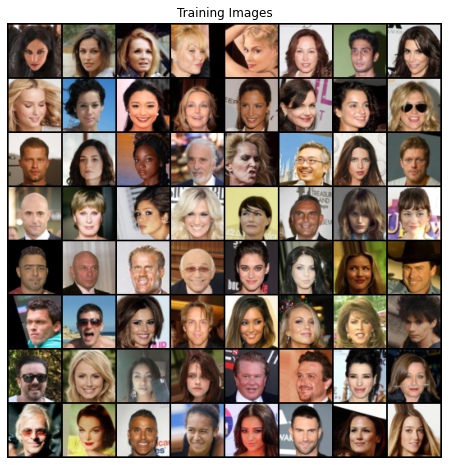

In [28]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataroot = "data/img_align_celeba/img_align_celeba_4"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig("face_orig.png")

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)
# Print the model

noise = torch.randn(batch_size, nz, 1, 1, device=device)
print(noise.shape)
        # Generate fake image batch with G
fake = netG(noise)
print(fake.shape)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
noise = torch.randn(359, 3, 64, 64, device=device)
print(noise.shape)
        # Generate fake image batch with G
fake = netD(noise)
print(fake.shape)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
torch.Size([359, 3, 64, 64])
t

In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [23]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/1583]	Loss_D: 0.6177	Loss_G: 1.8377	D(x): 0.6554	D(G(z)): 0.1237 / 0.2003
[0/50][50/1583]	Loss_D: 1.0037	Loss_G: 0.6365	D(x): 0.4484	D(G(z)): 0.0691 / 0.5611
[0/50][100/1583]	Loss_D: 0.6320	Loss_G: 2.3852	D(x): 0.7456	D(G(z)): 0.2419 / 0.1145
[0/50][150/1583]	Loss_D: 0.7633	Loss_G: 1.5398	D(x): 0.5622	D(G(z)): 0.1019 / 0.2538
[0/50][200/1583]	Loss_D: 1.8416	Loss_G: 0.1981	D(x): 0.2253	D(G(z)): 0.0243 / 0.8393
[0/50][250/1583]	Loss_D: 0.5050	Loss_G: 1.9356	D(x): 0.7739	D(G(z)): 0.1804 / 0.1840
[0/50][300/1583]	Loss_D: 0.7717	Loss_G: 3.3436	D(x): 0.8369	D(G(z)): 0.4105 / 0.0468
[0/50][350/1583]	Loss_D: 0.5099	Loss_G: 3.1187	D(x): 0.8448	D(G(z)): 0.2555 / 0.0586
[0/50][400/1583]	Loss_D: 0.5637	Loss_G: 2.3700	D(x): 0.7821	D(G(z)): 0.2326 / 0.1172
[0/50][450/1583]	Loss_D: 0.6197	Loss_G: 2.7612	D(x): 0.8133	D(G(z)): 0.3031 / 0.0810
[0/50][500/1583]	Loss_D: 1.2680	Loss_G: 1.0435	D(x): 0.3732	D(G(z)): 0.0350 / 0.4177
[0/50][550/1583]	Loss_D: 0.6140	Loss_G: 3.

[3/50][0/1583]	Loss_D: 0.6122	Loss_G: 3.8625	D(x): 0.8807	D(G(z)): 0.3348 / 0.0313
[3/50][50/1583]	Loss_D: 0.3565	Loss_G: 3.0900	D(x): 0.8607	D(G(z)): 0.1684 / 0.0631
[3/50][100/1583]	Loss_D: 0.5019	Loss_G: 3.7588	D(x): 0.9061	D(G(z)): 0.2916 / 0.0347
[3/50][150/1583]	Loss_D: 0.5375	Loss_G: 1.3617	D(x): 0.6719	D(G(z)): 0.0787 / 0.3028
[3/50][200/1583]	Loss_D: 0.3859	Loss_G: 2.6340	D(x): 0.8060	D(G(z)): 0.1207 / 0.1018
[3/50][250/1583]	Loss_D: 0.3461	Loss_G: 2.9542	D(x): 0.7669	D(G(z)): 0.0495 / 0.0766
[3/50][300/1583]	Loss_D: 0.8157	Loss_G: 4.9273	D(x): 0.9388	D(G(z)): 0.4778 / 0.0120
[3/50][350/1583]	Loss_D: 0.3442	Loss_G: 2.8961	D(x): 0.8531	D(G(z)): 0.1478 / 0.0755
[3/50][400/1583]	Loss_D: 0.5881	Loss_G: 5.6896	D(x): 0.9544	D(G(z)): 0.3778 / 0.0055
[3/50][450/1583]	Loss_D: 0.4838	Loss_G: 2.1805	D(x): 0.6911	D(G(z)): 0.0539 / 0.1532
[3/50][500/1583]	Loss_D: 0.2384	Loss_G: 3.3027	D(x): 0.9249	D(G(z)): 0.1362 / 0.0505
[3/50][550/1583]	Loss_D: 0.7251	Loss_G: 2.9004	D(x): 0.7287	D(G(z)):

[6/50][50/1583]	Loss_D: 0.2099	Loss_G: 3.1771	D(x): 0.9121	D(G(z)): 0.0996 / 0.0580
[6/50][100/1583]	Loss_D: 0.2189	Loss_G: 3.6387	D(x): 0.9270	D(G(z)): 0.1219 / 0.0378
[6/50][150/1583]	Loss_D: 0.5485	Loss_G: 5.1675	D(x): 0.9317	D(G(z)): 0.3336 / 0.0094
[6/50][200/1583]	Loss_D: 0.1661	Loss_G: 3.3903	D(x): 0.9161	D(G(z)): 0.0683 / 0.0503
[6/50][250/1583]	Loss_D: 0.2968	Loss_G: 2.3593	D(x): 0.8570	D(G(z)): 0.1086 / 0.1277
[6/50][300/1583]	Loss_D: 0.2523	Loss_G: 3.3022	D(x): 0.8898	D(G(z)): 0.1059 / 0.0571
[6/50][350/1583]	Loss_D: 0.2500	Loss_G: 4.0957	D(x): 0.9563	D(G(z)): 0.1738 / 0.0244
[6/50][400/1583]	Loss_D: 0.3345	Loss_G: 4.2480	D(x): 0.9500	D(G(z)): 0.2243 / 0.0213
[6/50][450/1583]	Loss_D: 0.6785	Loss_G: 5.2075	D(x): 0.9799	D(G(z)): 0.4269 / 0.0085
[6/50][500/1583]	Loss_D: 0.6615	Loss_G: 2.9218	D(x): 0.9114	D(G(z)): 0.3820 / 0.0852
[6/50][550/1583]	Loss_D: 0.2404	Loss_G: 3.1109	D(x): 0.8806	D(G(z)): 0.0915 / 0.0641
[6/50][600/1583]	Loss_D: 0.2135	Loss_G: 4.1392	D(x): 0.9546	D(G(z)

[9/50][100/1583]	Loss_D: 0.2867	Loss_G: 3.7850	D(x): 0.9338	D(G(z)): 0.1730 / 0.0338
[9/50][150/1583]	Loss_D: 0.1698	Loss_G: 4.3162	D(x): 0.9500	D(G(z)): 0.1037 / 0.0216
[9/50][200/1583]	Loss_D: 0.1115	Loss_G: 3.9135	D(x): 0.9656	D(G(z)): 0.0681 / 0.0347
[9/50][250/1583]	Loss_D: 0.1848	Loss_G: 3.7813	D(x): 0.9222	D(G(z)): 0.0824 / 0.0382
[9/50][300/1583]	Loss_D: 0.1849	Loss_G: 2.3518	D(x): 0.8922	D(G(z)): 0.0546 / 0.1321
[9/50][350/1583]	Loss_D: 3.1322	Loss_G: 4.5782	D(x): 0.9504	D(G(z)): 0.8945 / 0.0287
[9/50][400/1583]	Loss_D: 0.2587	Loss_G: 3.2148	D(x): 0.8388	D(G(z)): 0.0522 / 0.0775
[9/50][450/1583]	Loss_D: 1.9524	Loss_G: 4.6551	D(x): 0.9311	D(G(z)): 0.7602 / 0.0231
[9/50][500/1583]	Loss_D: 0.3659	Loss_G: 3.3485	D(x): 0.8554	D(G(z)): 0.1456 / 0.0569
[9/50][550/1583]	Loss_D: 0.3195	Loss_G: 3.8754	D(x): 0.9021	D(G(z)): 0.1477 / 0.0380
[9/50][600/1583]	Loss_D: 0.4388	Loss_G: 2.4610	D(x): 0.7387	D(G(z)): 0.0891 / 0.1224
[9/50][650/1583]	Loss_D: 0.6814	Loss_G: 4.0844	D(x): 0.9139	D(G(z

[12/50][100/1583]	Loss_D: 0.1448	Loss_G: 4.1108	D(x): 0.9381	D(G(z)): 0.0647 / 0.0313
[12/50][150/1583]	Loss_D: 0.1014	Loss_G: 3.4583	D(x): 0.9406	D(G(z)): 0.0364 / 0.0517
[12/50][200/1583]	Loss_D: 0.0780	Loss_G: 4.1906	D(x): 0.9902	D(G(z)): 0.0626 / 0.0227
[12/50][250/1583]	Loss_D: 0.1279	Loss_G: 4.3831	D(x): 0.9562	D(G(z)): 0.0740 / 0.0219
[12/50][300/1583]	Loss_D: 0.8692	Loss_G: 1.8490	D(x): 0.6154	D(G(z)): 0.2242 / 0.2198
[12/50][350/1583]	Loss_D: 0.4263	Loss_G: 2.3424	D(x): 0.7748	D(G(z)): 0.1093 / 0.1436
[12/50][400/1583]	Loss_D: 0.2478	Loss_G: 3.3630	D(x): 0.8577	D(G(z)): 0.0594 / 0.0740
[12/50][450/1583]	Loss_D: 0.2868	Loss_G: 7.1887	D(x): 0.9846	D(G(z)): 0.2043 / 0.0012
[12/50][500/1583]	Loss_D: 0.1575	Loss_G: 4.8723	D(x): 0.9485	D(G(z)): 0.0904 / 0.0144
[12/50][550/1583]	Loss_D: 0.2099	Loss_G: 5.2673	D(x): 0.9902	D(G(z)): 0.1574 / 0.0091
[12/50][600/1583]	Loss_D: 0.1397	Loss_G: 4.0408	D(x): 0.9347	D(G(z)): 0.0610 / 0.0323
[12/50][650/1583]	Loss_D: 0.0954	Loss_G: 4.2369	D(x): 

[15/50][50/1583]	Loss_D: 0.0436	Loss_G: 5.3308	D(x): 0.9777	D(G(z)): 0.0193 / 0.0103
[15/50][100/1583]	Loss_D: 0.9358	Loss_G: 2.6971	D(x): 0.8017	D(G(z)): 0.4418 / 0.1024
[15/50][150/1583]	Loss_D: 0.1011	Loss_G: 5.1834	D(x): 0.9752	D(G(z)): 0.0650 / 0.0119
[15/50][200/1583]	Loss_D: 0.1113	Loss_G: 2.9277	D(x): 0.9257	D(G(z)): 0.0260 / 0.0905
[15/50][250/1583]	Loss_D: 0.0510	Loss_G: 5.0760	D(x): 0.9890	D(G(z)): 0.0367 / 0.0110
[15/50][300/1583]	Loss_D: 0.0789	Loss_G: 5.6612	D(x): 0.9885	D(G(z)): 0.0558 / 0.0059
[15/50][350/1583]	Loss_D: 0.0691	Loss_G: 4.7110	D(x): 0.9864	D(G(z)): 0.0497 / 0.0184
[15/50][400/1583]	Loss_D: 0.0304	Loss_G: 5.1062	D(x): 0.9865	D(G(z)): 0.0160 / 0.0120
[15/50][450/1583]	Loss_D: 2.5841	Loss_G: 0.1404	D(x): 0.1346	D(G(z)): 0.0055 / 0.9011
[15/50][500/1583]	Loss_D: 0.1080	Loss_G: 4.8521	D(x): 0.9599	D(G(z)): 0.0576 / 0.0144
[15/50][550/1583]	Loss_D: 0.8667	Loss_G: 2.6950	D(x): 0.7900	D(G(z)): 0.3901 / 0.1181
[15/50][600/1583]	Loss_D: 0.2407	Loss_G: 4.5496	D(x): 0

[18/50][0/1583]	Loss_D: 0.0845	Loss_G: 4.0297	D(x): 0.9410	D(G(z)): 0.0199 / 0.0323
[18/50][50/1583]	Loss_D: 0.0590	Loss_G: 4.6753	D(x): 0.9674	D(G(z)): 0.0237 / 0.0187
[18/50][100/1583]	Loss_D: 0.0515	Loss_G: 4.7264	D(x): 0.9626	D(G(z)): 0.0120 / 0.0205
[18/50][150/1583]	Loss_D: 0.0589	Loss_G: 4.9225	D(x): 0.9679	D(G(z)): 0.0239 / 0.0142
[18/50][200/1583]	Loss_D: 4.4813	Loss_G: 0.5736	D(x): 0.0286	D(G(z)): 0.0024 / 0.6324
[18/50][250/1583]	Loss_D: 0.0940	Loss_G: 4.8157	D(x): 0.9697	D(G(z)): 0.0527 / 0.0157
[18/50][300/1583]	Loss_D: 1.4151	Loss_G: 6.4053	D(x): 0.9887	D(G(z)): 0.6688 / 0.0053
[18/50][350/1583]	Loss_D: 0.0720	Loss_G: 5.0828	D(x): 0.9825	D(G(z)): 0.0486 / 0.0136
[18/50][400/1583]	Loss_D: 0.4285	Loss_G: 2.9456	D(x): 0.8050	D(G(z)): 0.1271 / 0.0921
[18/50][450/1583]	Loss_D: 0.7466	Loss_G: 2.1461	D(x): 0.6333	D(G(z)): 0.1386 / 0.1961
[18/50][500/1583]	Loss_D: 0.6081	Loss_G: 4.2690	D(x): 0.8903	D(G(z)): 0.3232 / 0.0222
[18/50][550/1583]	Loss_D: 1.8857	Loss_G: 1.1916	D(x): 0.2

[20/50][1550/1583]	Loss_D: 0.2352	Loss_G: 2.8095	D(x): 0.8259	D(G(z)): 0.0106 / 0.1327
[21/50][0/1583]	Loss_D: 0.0632	Loss_G: 5.5927	D(x): 0.9768	D(G(z)): 0.0343 / 0.0086
[21/50][50/1583]	Loss_D: 0.1343	Loss_G: 3.5159	D(x): 0.9136	D(G(z)): 0.0340 / 0.0600
[21/50][100/1583]	Loss_D: 0.0766	Loss_G: 4.6088	D(x): 0.9404	D(G(z)): 0.0091 / 0.0211
[21/50][150/1583]	Loss_D: 0.0432	Loss_G: 5.1249	D(x): 0.9672	D(G(z)): 0.0083 / 0.0139
[21/50][200/1583]	Loss_D: 0.6491	Loss_G: 2.1980	D(x): 0.7529	D(G(z)): 0.2531 / 0.1595
[21/50][250/1583]	Loss_D: 0.3192	Loss_G: 7.2562	D(x): 0.9918	D(G(z)): 0.2095 / 0.0014
[21/50][300/1583]	Loss_D: 0.0680	Loss_G: 4.9197	D(x): 0.9603	D(G(z)): 0.0226 / 0.0175
[21/50][350/1583]	Loss_D: 0.0638	Loss_G: 5.1990	D(x): 0.9915	D(G(z)): 0.0508 / 0.0114
[21/50][400/1583]	Loss_D: 0.0600	Loss_G: 4.7860	D(x): 0.9721	D(G(z)): 0.0273 / 0.0164
[21/50][450/1583]	Loss_D: 0.0531	Loss_G: 5.2934	D(x): 0.9706	D(G(z)): 0.0199 / 0.0128
[21/50][500/1583]	Loss_D: 0.0806	Loss_G: 4.3931	D(x): 0.

[23/50][1500/1583]	Loss_D: 0.0276	Loss_G: 4.9171	D(x): 0.9913	D(G(z)): 0.0182 / 0.0158
[23/50][1550/1583]	Loss_D: 0.0315	Loss_G: 5.7075	D(x): 0.9794	D(G(z)): 0.0097 / 0.0083
[24/50][0/1583]	Loss_D: 0.0547	Loss_G: 5.2214	D(x): 0.9852	D(G(z)): 0.0351 / 0.0125
[24/50][50/1583]	Loss_D: 0.0317	Loss_G: 4.9866	D(x): 0.9810	D(G(z)): 0.0113 / 0.0142
[24/50][100/1583]	Loss_D: 0.0519	Loss_G: 5.5219	D(x): 0.9893	D(G(z)): 0.0384 / 0.0078
[24/50][150/1583]	Loss_D: 0.0249	Loss_G: 6.0746	D(x): 0.9931	D(G(z)): 0.0173 / 0.0058
[24/50][200/1583]	Loss_D: 0.4485	Loss_G: 2.5805	D(x): 0.7538	D(G(z)): 0.0971 / 0.1136
[24/50][250/1583]	Loss_D: 0.0951	Loss_G: 4.9222	D(x): 0.9844	D(G(z)): 0.0694 / 0.0154
[24/50][300/1583]	Loss_D: 0.2918	Loss_G: 2.3377	D(x): 0.8149	D(G(z)): 0.0104 / 0.1881
[24/50][350/1583]	Loss_D: 0.0443	Loss_G: 6.0815	D(x): 0.9703	D(G(z)): 0.0124 / 0.0068
[24/50][400/1583]	Loss_D: 0.0505	Loss_G: 5.4819	D(x): 0.9766	D(G(z)): 0.0212 / 0.0108
[24/50][450/1583]	Loss_D: 0.4925	Loss_G: 2.0880	D(x): 0

[26/50][1450/1583]	Loss_D: 0.0266	Loss_G: 5.6088	D(x): 0.9892	D(G(z)): 0.0149 / 0.0080
[26/50][1500/1583]	Loss_D: 0.0466	Loss_G: 5.8054	D(x): 0.9809	D(G(z)): 0.0137 / 0.0072
[26/50][1550/1583]	Loss_D: 0.1850	Loss_G: 1.7997	D(x): 0.8584	D(G(z)): 0.0130 / 0.2981
[27/50][0/1583]	Loss_D: 0.3049	Loss_G: 3.5036	D(x): 0.8800	D(G(z)): 0.1202 / 0.0551
[27/50][50/1583]	Loss_D: 0.0245	Loss_G: 5.8493	D(x): 0.9918	D(G(z)): 0.0156 / 0.0075
[27/50][100/1583]	Loss_D: 0.0328	Loss_G: 6.2133	D(x): 0.9899	D(G(z)): 0.0211 / 0.0049
[27/50][150/1583]	Loss_D: 0.0496	Loss_G: 5.2907	D(x): 0.9574	D(G(z)): 0.0037 / 0.0121
[27/50][200/1583]	Loss_D: 0.0450	Loss_G: 5.3395	D(x): 0.9731	D(G(z)): 0.0156 / 0.0111
[27/50][250/1583]	Loss_D: 0.0321	Loss_G: 5.9523	D(x): 0.9895	D(G(z)): 0.0204 / 0.0064
[27/50][300/1583]	Loss_D: 0.3416	Loss_G: 2.0577	D(x): 0.7945	D(G(z)): 0.0519 / 0.2033
[27/50][350/1583]	Loss_D: 0.9488	Loss_G: 0.7526	D(x): 0.4980	D(G(z)): 0.0172 / 0.5955
[27/50][400/1583]	Loss_D: 0.0719	Loss_G: 4.4365	D(x): 

[29/50][1400/1583]	Loss_D: 0.1834	Loss_G: 3.6666	D(x): 0.8891	D(G(z)): 0.0311 / 0.0675
[29/50][1450/1583]	Loss_D: 0.0504	Loss_G: 6.2151	D(x): 0.9580	D(G(z)): 0.0040 / 0.0062
[29/50][1500/1583]	Loss_D: 0.0517	Loss_G: 4.8582	D(x): 0.9711	D(G(z)): 0.0157 / 0.0213
[29/50][1550/1583]	Loss_D: 0.1137	Loss_G: 5.3466	D(x): 0.9033	D(G(z)): 0.0021 / 0.0149
[30/50][0/1583]	Loss_D: 0.0485	Loss_G: 6.1216	D(x): 0.9851	D(G(z)): 0.0308 / 0.0051
[30/50][50/1583]	Loss_D: 0.0385	Loss_G: 5.3934	D(x): 0.9896	D(G(z)): 0.0266 / 0.0104
[30/50][100/1583]	Loss_D: 0.0273	Loss_G: 5.6671	D(x): 0.9866	D(G(z)): 0.0132 / 0.0083
[30/50][150/1583]	Loss_D: 1.1636	Loss_G: 0.7769	D(x): 0.4436	D(G(z)): 0.0563 / 0.5595
[30/50][200/1583]	Loss_D: 0.6496	Loss_G: 4.3287	D(x): 0.8656	D(G(z)): 0.3124 / 0.0270
[30/50][250/1583]	Loss_D: 0.2457	Loss_G: 5.6317	D(x): 0.9929	D(G(z)): 0.1718 / 0.0087
[30/50][300/1583]	Loss_D: 0.9867	Loss_G: 0.0548	D(x): 0.5184	D(G(z)): 0.0025 / 0.9547
[30/50][350/1583]	Loss_D: 0.2890	Loss_G: 7.8622	D(x):

[32/50][1350/1583]	Loss_D: 0.1296	Loss_G: 4.9126	D(x): 0.9119	D(G(z)): 0.0271 / 0.0162
[32/50][1400/1583]	Loss_D: 0.1308	Loss_G: 4.5289	D(x): 0.9547	D(G(z)): 0.0664 / 0.0262
[32/50][1450/1583]	Loss_D: 0.3344	Loss_G: 3.4254	D(x): 0.8720	D(G(z)): 0.1425 / 0.0669
[32/50][1500/1583]	Loss_D: 0.0489	Loss_G: 6.3329	D(x): 0.9655	D(G(z)): 0.0104 / 0.0057
[32/50][1550/1583]	Loss_D: 0.0905	Loss_G: 3.8802	D(x): 0.9477	D(G(z)): 0.0273 / 0.0438
[33/50][0/1583]	Loss_D: 0.5409	Loss_G: 2.8831	D(x): 0.7910	D(G(z)): 0.1905 / 0.0969
[33/50][50/1583]	Loss_D: 0.1918	Loss_G: 4.5717	D(x): 0.8522	D(G(z)): 0.0027 / 0.0361
[33/50][100/1583]	Loss_D: 0.0445	Loss_G: 5.8248	D(x): 0.9903	D(G(z)): 0.0314 / 0.0074
[33/50][150/1583]	Loss_D: 1.1766	Loss_G: 1.1339	D(x): 0.4148	D(G(z)): 0.0001 / 0.4347
[33/50][200/1583]	Loss_D: 0.0858	Loss_G: 5.8291	D(x): 0.9832	D(G(z)): 0.0587 / 0.0064
[33/50][250/1583]	Loss_D: 0.0366	Loss_G: 6.0701	D(x): 0.9935	D(G(z)): 0.0274 / 0.0058
[33/50][300/1583]	Loss_D: 0.2554	Loss_G: 3.5052	D(x)

[35/50][1300/1583]	Loss_D: 0.0541	Loss_G: 5.3116	D(x): 0.9683	D(G(z)): 0.0157 / 0.0115
[35/50][1350/1583]	Loss_D: 0.2781	Loss_G: 2.6182	D(x): 0.8724	D(G(z)): 0.0952 / 0.1465
[35/50][1400/1583]	Loss_D: 0.0405	Loss_G: 5.4376	D(x): 0.9883	D(G(z)): 0.0266 / 0.0126
[35/50][1450/1583]	Loss_D: 0.6656	Loss_G: 11.5535	D(x): 0.9991	D(G(z)): 0.3875 / 0.0000
[35/50][1500/1583]	Loss_D: 0.0576	Loss_G: 5.3188	D(x): 0.9821	D(G(z)): 0.0355 / 0.0128
[35/50][1550/1583]	Loss_D: 1.3707	Loss_G: 6.9037	D(x): 0.9935	D(G(z)): 0.6061 / 0.0050
[36/50][0/1583]	Loss_D: 0.0635	Loss_G: 5.1281	D(x): 0.9538	D(G(z)): 0.0112 / 0.0170
[36/50][50/1583]	Loss_D: 0.0484	Loss_G: 5.8723	D(x): 0.9668	D(G(z)): 0.0103 / 0.0095
[36/50][100/1583]	Loss_D: 0.0446	Loss_G: 5.4462	D(x): 0.9770	D(G(z)): 0.0189 / 0.0107
[36/50][150/1583]	Loss_D: 0.0144	Loss_G: 6.3341	D(x): 0.9929	D(G(z)): 0.0071 / 0.0060
[36/50][200/1583]	Loss_D: 0.0327	Loss_G: 5.0588	D(x): 0.9844	D(G(z)): 0.0152 / 0.0135
[36/50][250/1583]	Loss_D: 0.0285	Loss_G: 5.7457	D(

[38/50][1250/1583]	Loss_D: 3.4003	Loss_G: 10.1119	D(x): 0.9972	D(G(z)): 0.9136 / 0.0003
[38/50][1300/1583]	Loss_D: 0.1283	Loss_G: 6.9300	D(x): 0.9898	D(G(z)): 0.0904 / 0.0026
[38/50][1350/1583]	Loss_D: 0.5896	Loss_G: 1.7597	D(x): 0.7865	D(G(z)): 0.2061 / 0.2617
[38/50][1400/1583]	Loss_D: 0.4264	Loss_G: 9.0454	D(x): 0.9800	D(G(z)): 0.2814 / 0.0003
[38/50][1450/1583]	Loss_D: 0.0873	Loss_G: 6.2574	D(x): 0.9705	D(G(z)): 0.0382 / 0.0048
[38/50][1500/1583]	Loss_D: 0.0500	Loss_G: 5.2307	D(x): 0.9650	D(G(z)): 0.0102 / 0.0145
[38/50][1550/1583]	Loss_D: 0.0265	Loss_G: 5.9463	D(x): 0.9933	D(G(z)): 0.0190 / 0.0072
[39/50][0/1583]	Loss_D: 0.1672	Loss_G: 9.2696	D(x): 0.9966	D(G(z)): 0.1237 / 0.0002
[39/50][50/1583]	Loss_D: 0.0835	Loss_G: 4.4794	D(x): 0.9368	D(G(z)): 0.0099 / 0.0296
[39/50][100/1583]	Loss_D: 0.0349	Loss_G: 5.7182	D(x): 0.9827	D(G(z)): 0.0156 / 0.0092
[39/50][150/1583]	Loss_D: 0.0974	Loss_G: 7.8437	D(x): 0.9985	D(G(z)): 0.0804 / 0.0009
[39/50][200/1583]	Loss_D: 0.0383	Loss_G: 5.8924	D

[41/50][1200/1583]	Loss_D: 0.0344	Loss_G: 6.0915	D(x): 0.9936	D(G(z)): 0.0252 / 0.0064
[41/50][1250/1583]	Loss_D: 0.0501	Loss_G: 5.8959	D(x): 0.9831	D(G(z)): 0.0301 / 0.0061
[41/50][1300/1583]	Loss_D: 0.5719	Loss_G: 2.7355	D(x): 0.7946	D(G(z)): 0.1881 / 0.1164
[41/50][1350/1583]	Loss_D: 1.1057	Loss_G: 7.4803	D(x): 0.9884	D(G(z)): 0.5360 / 0.0016
[41/50][1400/1583]	Loss_D: 0.2047	Loss_G: 4.2494	D(x): 0.9651	D(G(z)): 0.1005 / 0.0407
[41/50][1450/1583]	Loss_D: 0.0423	Loss_G: 6.0856	D(x): 0.9784	D(G(z)): 0.0145 / 0.0066
[41/50][1500/1583]	Loss_D: 0.4234	Loss_G: 2.9803	D(x): 0.7414	D(G(z)): 0.0371 / 0.1070
[41/50][1550/1583]	Loss_D: 1.4395	Loss_G: 5.9710	D(x): 0.3809	D(G(z)): 0.0003 / 0.0171
[42/50][0/1583]	Loss_D: 0.0414	Loss_G: 5.4869	D(x): 0.9855	D(G(z)): 0.0244 / 0.0105
[42/50][50/1583]	Loss_D: 0.0701	Loss_G: 4.9000	D(x): 0.9498	D(G(z)): 0.0117 / 0.0244
[42/50][100/1583]	Loss_D: 0.0550	Loss_G: 5.8629	D(x): 0.9785	D(G(z)): 0.0186 / 0.0091
[42/50][150/1583]	Loss_D: 0.0313	Loss_G: 5.6389	D

[44/50][1150/1583]	Loss_D: 0.0335	Loss_G: 5.5744	D(x): 0.9853	D(G(z)): 0.0169 / 0.0104
[44/50][1200/1583]	Loss_D: 0.4994	Loss_G: 5.0544	D(x): 0.9515	D(G(z)): 0.2850 / 0.0141
[44/50][1250/1583]	Loss_D: 0.1404	Loss_G: 4.4673	D(x): 0.9619	D(G(z)): 0.0850 / 0.0243
[44/50][1300/1583]	Loss_D: 0.0454	Loss_G: 6.6241	D(x): 0.9977	D(G(z)): 0.0392 / 0.0036
[44/50][1350/1583]	Loss_D: 0.3465	Loss_G: 4.2621	D(x): 0.9039	D(G(z)): 0.1584 / 0.0410
[44/50][1400/1583]	Loss_D: 0.0820	Loss_G: 5.0463	D(x): 0.9699	D(G(z)): 0.0434 / 0.0256
[44/50][1450/1583]	Loss_D: 0.0285	Loss_G: 5.7578	D(x): 0.9829	D(G(z)): 0.0103 / 0.0093
[44/50][1500/1583]	Loss_D: 0.4879	Loss_G: 3.0611	D(x): 0.8051	D(G(z)): 0.1486 / 0.0900
[44/50][1550/1583]	Loss_D: 0.6829	Loss_G: 0.6884	D(x): 0.6196	D(G(z)): 0.0022 / 0.6477
[45/50][0/1583]	Loss_D: 0.1035	Loss_G: 4.8882	D(x): 0.9583	D(G(z)): 0.0456 / 0.0172
[45/50][50/1583]	Loss_D: 0.0299	Loss_G: 6.9224	D(x): 0.9777	D(G(z)): 0.0057 / 0.0030
[45/50][100/1583]	Loss_D: 0.0938	Loss_G: 5.1048	

[47/50][1100/1583]	Loss_D: 1.3511	Loss_G: 3.1729	D(x): 0.4191	D(G(z)): 0.0007 / 0.1209
[47/50][1150/1583]	Loss_D: 0.3844	Loss_G: 4.4847	D(x): 0.8958	D(G(z)): 0.1765 / 0.0298
[47/50][1200/1583]	Loss_D: 0.2682	Loss_G: 4.7858	D(x): 0.9268	D(G(z)): 0.1301 / 0.0211
[47/50][1250/1583]	Loss_D: 0.0633	Loss_G: 5.5002	D(x): 0.9666	D(G(z)): 0.0239 / 0.0115
[47/50][1300/1583]	Loss_D: 0.0452	Loss_G: 6.2445	D(x): 0.9733	D(G(z)): 0.0062 / 0.0061
[47/50][1350/1583]	Loss_D: 0.0628	Loss_G: 4.6717	D(x): 0.9507	D(G(z)): 0.0084 / 0.0273
[47/50][1400/1583]	Loss_D: 0.0933	Loss_G: 4.1061	D(x): 0.9198	D(G(z)): 0.0019 / 0.0456
[47/50][1450/1583]	Loss_D: 0.0125	Loss_G: 6.6766	D(x): 0.9917	D(G(z)): 0.0039 / 0.0039
[47/50][1500/1583]	Loss_D: 0.0377	Loss_G: 6.7877	D(x): 0.9984	D(G(z)): 0.0327 / 0.0029
[47/50][1550/1583]	Loss_D: 0.0422	Loss_G: 6.4640	D(x): 0.9630	D(G(z)): 0.0027 / 0.0058
[48/50][0/1583]	Loss_D: 0.0449	Loss_G: 6.6553	D(x): 0.9911	D(G(z)): 0.0275 / 0.0032
[48/50][50/1583]	Loss_D: 0.2348	Loss_G: 4.4902

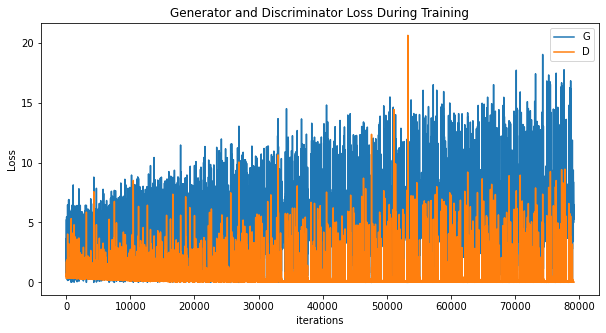

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('face_loss.png')

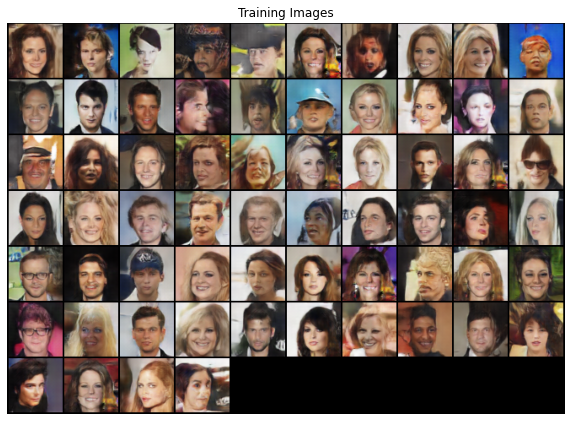

In [27]:
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
with torch.no_grad():
    inputs = netG(fixed_noise).detach().cpu()
       # print('fake sahpe is ',inputs.shape)
    #print('fake sahpe is ',inputs.shape)
plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
inputs = utils.make_grid(inputs[:100]*0.5+0.5, nrow=10)
plt.imshow(inputs.permute(1, 2, 0))
plt.savefig('face_syn.png')

In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, (4,4), (1,1), (0,0), bias=False), #1
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 7, (2,2), (2,1), (1,0), bias=False),#2
            nn.BatchNorm2d(ngf * 7),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 7, ngf * 6, (2,2), (2,1), (1,0), bias=False),#3
            nn.BatchNorm2d(ngf * 6),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 6, ngf* 5, (3,2), (2,1), (1,0), bias=False),#4
            nn.BatchNorm2d(ngf* 5),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf* 5, ngf* 4, (3,2), (2,1), (1,0), bias=False),#5
            nn.BatchNorm2d(ngf* 4),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf * 4, ngf * 3, (3,2), (2,1), (1,0), bias=False),#6
            nn.BatchNorm2d(ngf* 3),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf*3, ngf*2, (3,2), (2,1), (0,0), bias=False),#7
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf*2, ngf, (3,2), (1,1), (0,0), bias=False),#8
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 1, (2,2), (1,1), (0,0), bias=False),#9
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
#print(netG)
# Print the model

noise = torch.randn(b_size, nz, 1, 1, device=device)
print(noise.shape)
        # Generate fake image batch with G
fake = netG(noise)
print(fake.shape)

torch.Size([103, 100, 1, 1])
torch.Size([103, 1, 150, 12])


In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(
            print('ok'),
            nn.Conv2d(1, 10, (3,3),(2,1,),(0,0),bias=False), 

            # input is (nc) x 64 x 64
            nn.Conv2d(10, 20, (3,3),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(20, 40, (3,3),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(40, 80, (3,3),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(80),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(80, 160, (3,2),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(160),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(160, 320, (3,2),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(320),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(320, 1, (3,2),(1,1,),(0,0), bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [17]:

netD = Discriminator(ngpu)
netD.apply(weights_init)
print(netD)
noise = torch.randn(359, 1, 150, 12)
print(noise.shape)
        # Generate fake image batch with G
fake = netD(noise)
print('fake',fake.shape)



ok
Discriminator(
  (main): Sequential(
    (0): None
    (1): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 1), bias=False)
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 1), bias=False)
    (6): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 1), bias=False)
    (9): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(80, 160, kernel_size=(3, 2), stride=(2, 1), bias=False)
    (12): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(1

TypeError: 'NoneType' object is not callable

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        print('test+++++++++++++')
        self.conv = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 20, (5,12)), 
            ##shape from 365*5  to 20*361
            nn.BatchNorm2d(20),
            nn.ReLU(),
            Reshape(1,20,146),  #361
            nn.MaxPool2d((1,13), (1,1)), 
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.6),
            #1*20*361(361-13+1)
            nn.Linear(1*20*134, 120),#349
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(84, 2)
            nn.Tanh()
        )
    def forward(self, img):
       # print(img.shape)
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        output = torch.softmax(output,dim = 1)
        return output
     

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(
            print('ok'),
            nn.Conv2d(1, 10, (5,12),(1,1),(0,0),bias=False), 
            nn.Tanh(),
            
            print('what')

           
        )
    def forward(self, input):
        return self.main(input)
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view((x.size(0),)+self.shape)
#netD = Discriminator(ngpu).to(device)
#netD.apply(weights_init)
netD = Discriminator(ngpu)
netD.apply(weights_init)
print(netD)
noise = torch.randn(359, 1, 150, 12)
print(noise.shape)
        # Generate fake image batch with G
fake = netD(noise)
print('fake',fake.shape)



In [18]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, 10, (3,3),(2,1,),(1,0),bias=False), 
          #  print('ok jb'),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(10, 20, (3,3),(2,1,),(1,0), bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(20, 40, (3,3),(2,1,),(2,0), bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(40, 80, (3,3),(2,1,),(1,0), bias=False),
            nn.BatchNorm2d(80),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(80, 160, (3,2),(2,1,),(2,0), bias=False),
            nn.BatchNorm2d(160),
            nn.LeakyReLU(0.2, inplace=True),     
            
            nn.Conv2d(160, 320, (3,2),(2,1,),(1,0), bias=False),
            nn.BatchNorm2d(320),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(320, 1, (3,2),(1,1,),(0,0), bias=False),
            nn.Tanh()
            )

    def forward(self, input):
        return self.main(input)
    
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
noise = torch.randn(359, 1, 150, 12, device=device)
print(noise.shape)
        # Generate fake image batch with G
fake = netD(noise)
print(fake.shape)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 1), padding=(1, 0), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 1), padding=(1, 0), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 1), padding=(2, 0), bias=False)
    (6): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 1), padding=(1, 0), bias=False)
    (9): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(80, 160, kernel_size=(3, 2), stride=(2, 1), padding=(2, 0), bias=False)
    (12): BatchNorm2d(160, eps=1e-05, momentum=

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(
            print('ok'),
            nn.Conv2d(1, 10, (3,3),(2,1,),(0,0),bias=False), 

            # input is (nc) x 64 x 64
            nn.Conv2d(10, 20, (3,3),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(20, 40, (3,3),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(40, 80, (3,3),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(80),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(80, 160, (3,2),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(160),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(160, 320, (3,2),(2,1,),(0,0), bias=False),
            nn.BatchNorm2d(320),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(320, 1, (3,2),(1,1,),(0,0), bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)